In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

tampa_df = pd.read_csv ('tampa.csv')
read_dis_df = pd.read_csv ('disasters.csv')

/tmp/ipykernel_185034/3198870616.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Declaration Date'] = pd.to_datetime(filtered_df['Declaration Date'].copy())
/tmp/ipykernel_185034/3198870616.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scatter_df.loc[:, 'offset'] = (curr_date - filter_df['date'])
/tmp/ipykernel_185034/3198870616.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

89        6.000
125       4.750
137       4.750
213       5.000
235       6.250
          ...  
397745      NaN
397857    5.625
397879    5.625
397949      NaN
398169    5.875
Name: Current_Interest_Rate, Length: 5947, dtype: float64
517      NaN
805      NaN
1027     NaN
2013     NaN
2071     NaN
          ..
396747   NaN
396881   NaN
397745   NaN
397949   NaN
398109   NaN
Name: Current_Interest_Rate, Length: 959, dtype: float64
5        NaN
805      NaN
1027     NaN
2013     NaN
2071     NaN
          ..
396881   NaN
397827   NaN
397929   NaN
398109   NaN
398121   NaN
Name: Current_Interest_Rate, Length: 1141, dtype: float64
133      NaN
249      NaN
321      NaN
361      NaN
417      NaN
          ..
397753   NaN
397873   NaN
397969   NaN
398015   NaN
398179   NaN
Name: Current_Interest_Rate, Length: 2458, dtype: float64
215      NaN
253      NaN
679      NaN
865      NaN
913      NaN
          ..
397079   NaN
397445   NaN
397481   NaN
397579   NaN
397605   NaN
Name: Current_Interes

/tmp/ipykernel_185034/3198870616.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scatter_df.loc[:, 'offset'] = (curr_date - filter_df['date'])
/tmp/ipykernel_185034/3198870616.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scatter_df.loc[:, 'Offset from Hurricane'] = (scatter_df.copy())['offset'].dt.days
/tmp/ipykernel_185034/3198870616.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See th

25       NaN
211      NaN
325      NaN
477      NaN
491      NaN
          ..
398045   NaN
398047   NaN
398049   NaN
398135   NaN
398219   NaN
Name: Current_Interest_Rate, Length: 5480, dtype: float64
10        5.625
13          NaN
19          NaN
35          NaN
61          NaN
          ...  
398182    6.000
398192    5.750
398205      NaN
398206    6.000
398224    5.750
Name: Current_Interest_Rate, Length: 33439, dtype: float64
3           NaN
17          NaN
20        6.125
24        6.375
34        6.250
          ...  
398196    5.250
398209      NaN
398210    5.750
398217      NaN
398221      NaN
Name: Current_Interest_Rate, Length: 32405, dtype: float64
3           NaN
17          NaN
20        6.125
24        6.375
34        6.250
          ...  
398196    5.250
398209      NaN
398210    5.750
398217      NaN
398221      NaN
Name: Current_Interest_Rate, Length: 32405, dtype: float64


/tmp/ipykernel_185034/3198870616.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scatter_df.loc[:, 'offset'] = (curr_date - filter_df['date'])
/tmp/ipykernel_185034/3198870616.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scatter_df.loc[:, 'Offset from Hurricane'] = (scatter_df.copy())['offset'].dt.days
/tmp/ipykernel_185034/3198870616.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See th

3           NaN
17          NaN
20        6.125
24        6.375
34        6.250
          ...  
398196    5.250
398209      NaN
398210    5.750
398217      NaN
398221      NaN
Name: Current_Interest_Rate, Length: 33065, dtype: float64
1        NaN
31       NaN
39       NaN
101      NaN
113      NaN
          ..
398063   NaN
398107   NaN
398131   NaN
398165   NaN
398203   NaN
Name: Current_Interest_Rate, Length: 18528, dtype: float64
21       NaN
33       NaN
87       NaN
121      NaN
145      NaN
          ..
398005   NaN
398017   NaN
398019   NaN
398043   NaN
398173   NaN
Name: Current_Interest_Rate, Length: 9968, dtype: float64


/tmp/ipykernel_185034/3198870616.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scatter_df.loc[:, 'offset'] = (curr_date - filter_df['date'])
/tmp/ipykernel_185034/3198870616.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scatter_df.loc[:, 'Offset from Hurricane'] = (scatter_df.copy())['offset'].dt.days


Text(0.5, 0, 'OFFSET IN MONTHS')

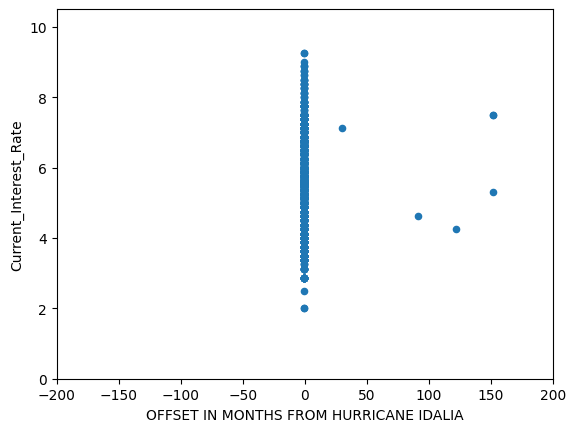

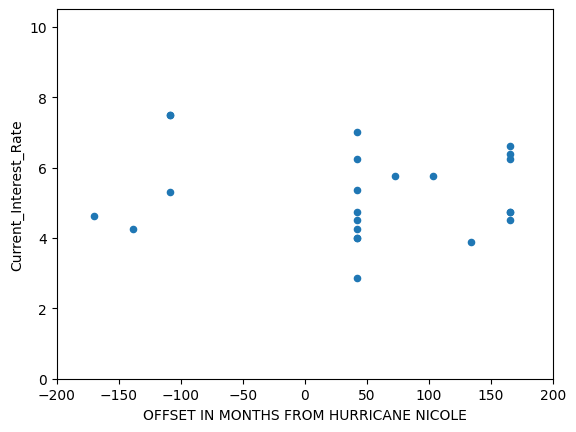

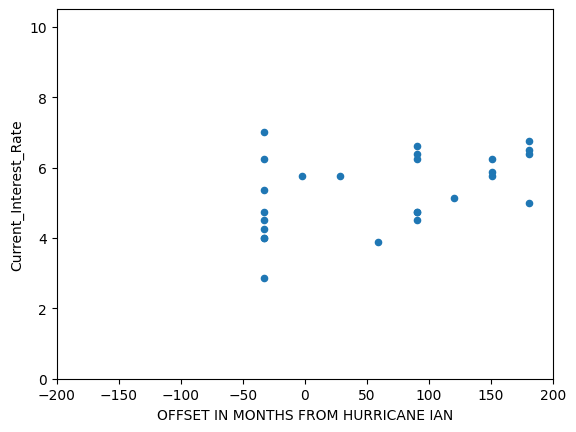

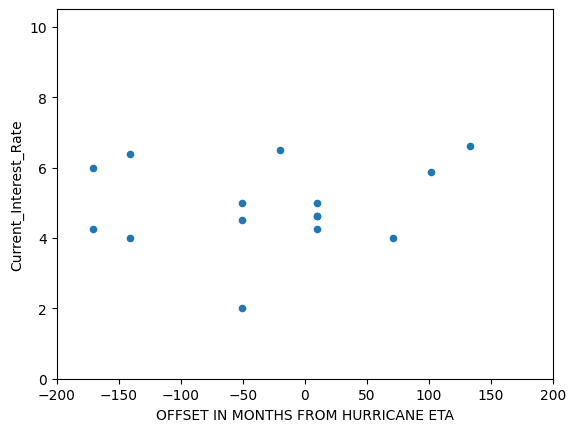

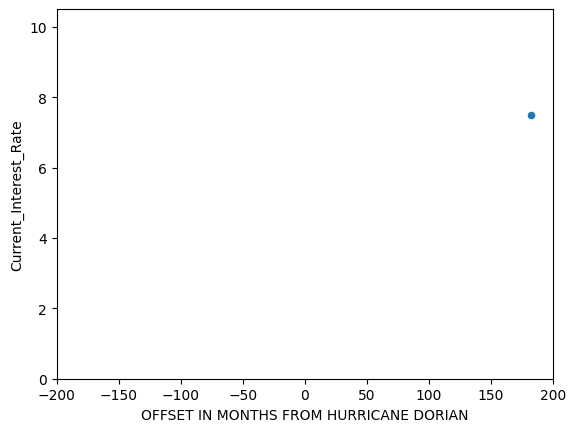

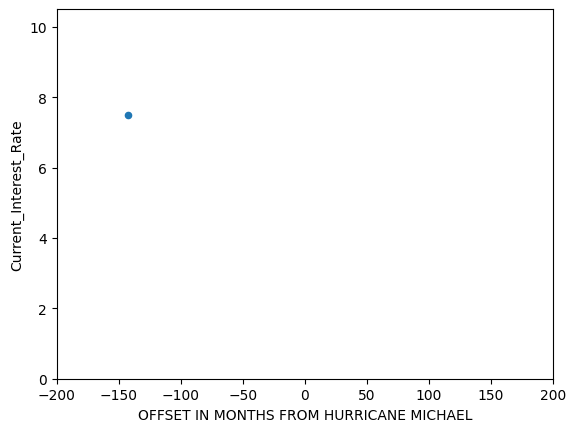

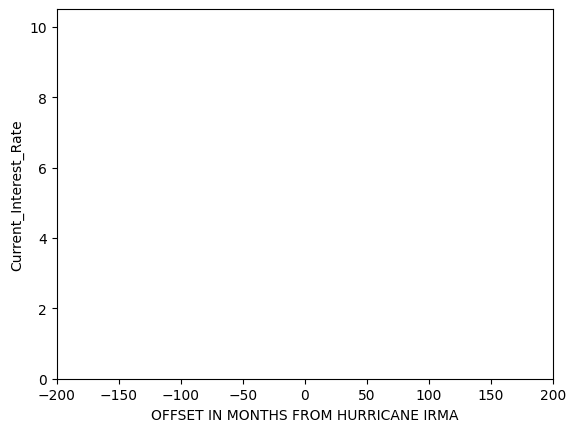

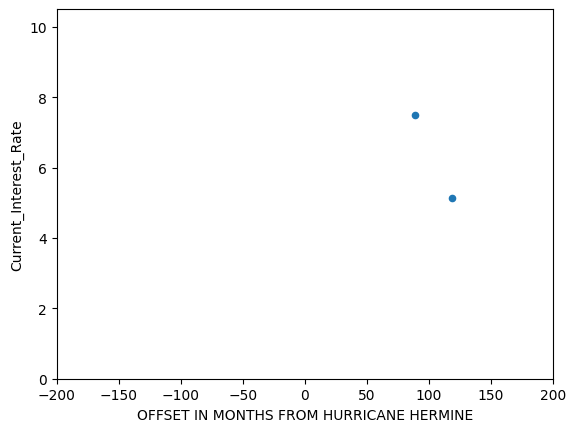

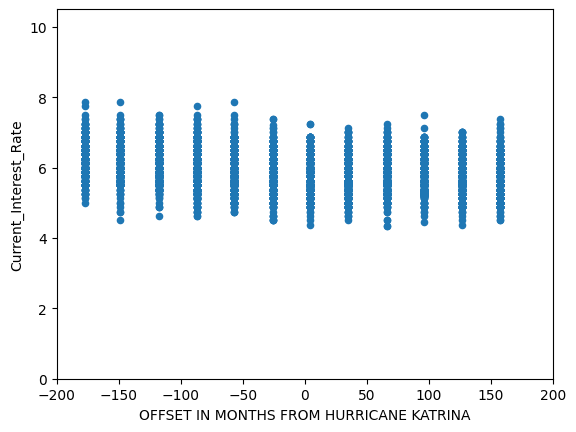

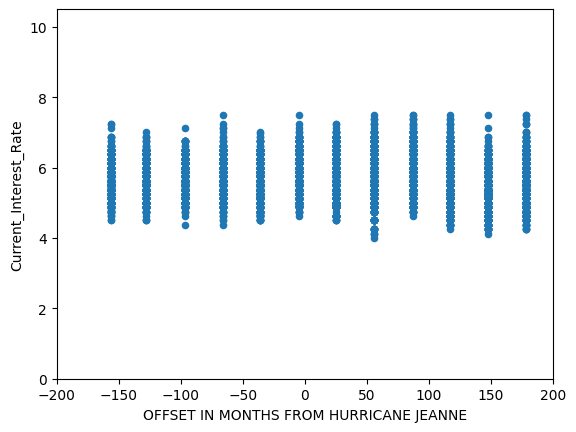

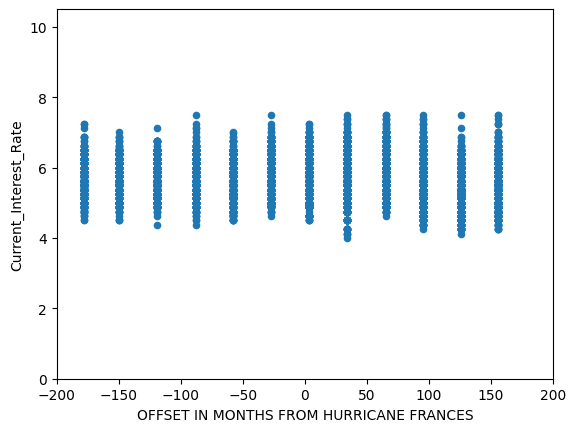

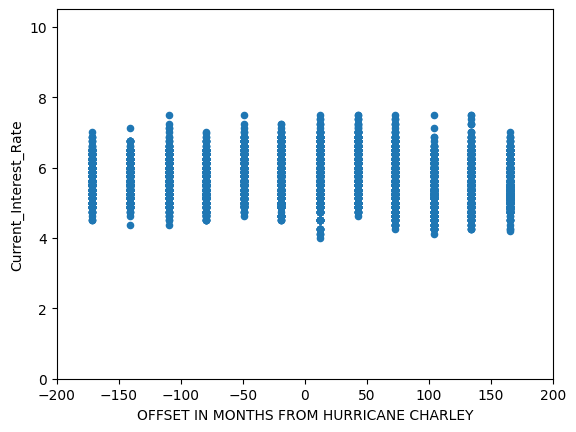

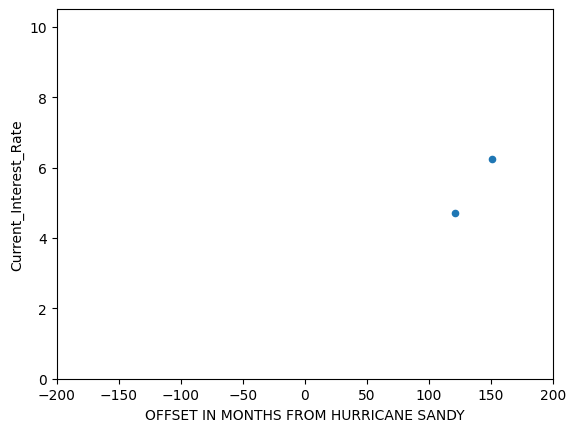

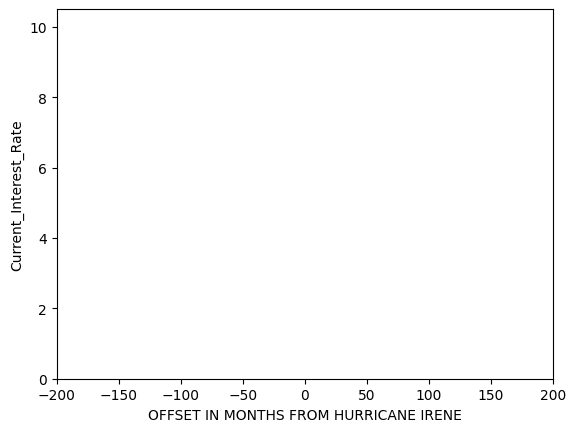

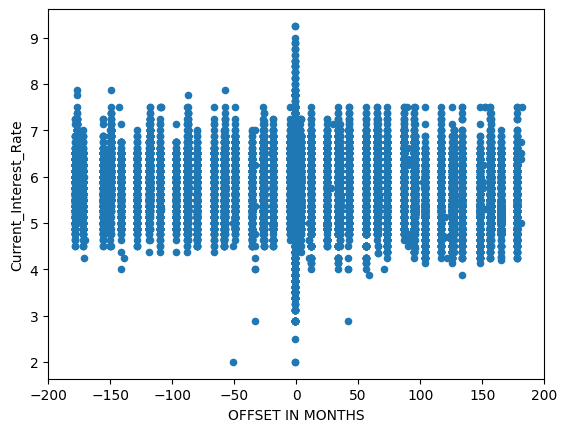

In [47]:
# filter to match what is in the city
counties = ['Hillsborough County', 'Pinellas County']
filtered_df = read_dis_df[read_dis_df['County'].isin(counties)]

# filter it so it doesn't go less than min year in tampa
filtered_df['Declaration Date'] = pd.to_datetime(filtered_df['Declaration Date'].copy())
min_year = tampa_df['PayYear'].min()
filtered_df = filtered_df[filtered_df['Declaration Date'].dt.year >= min_year]

# get all unique hurricane names
hurricane_names = filtered_df['Declaration Title'].str.extract(r'(HURRICANE\s+\w+)', expand=False).dropna()
hurricane_names = hurricane_names.unique()

disaster_df = pd.DataFrame({'hurricanes': hurricane_names})

# Create a dictionary mapping Hurricane names to Declaration Dates
hurricane_date_mapping = {}

for hurricane_name in disaster_df['hurricanes']:
    # Find matching Declaration Titles (considering variations)
    matching_titles = filtered_df[filtered_df['Declaration Title'].str.contains(hurricane_name, case=False)]['Declaration Title']
    if not matching_titles.empty:
        # Use the first matching Declaration Date
        hurricane_date_mapping[hurricane_name] = filtered_df.loc[filtered_df['Declaration Title'] == matching_titles.iloc[0], 'Declaration Date'].values[0]

# add in declaration date to new df
disaster_df['date'] = pd.to_datetime(disaster_df['hurricanes'].map(hurricane_date_mapping))

# add 6 months prior and after
disaster_df['-6 months'] = disaster_df['date'] - pd.DateOffset(months=6)
disaster_df['+6 months'] = disaster_df['date'] + pd.DateOffset(months=6)

# convert tampa data to date
tampa_df['date'] = pd.to_datetime(dict(year=tampa_df['PayYear'], month=tampa_df['PayMonth'], day=1))
master_fl_df = pd.DataFrame()

housing_info = 'Foreclosure_costs'

# go through each hurricane
for x in range(0, len(disaster_df)):
    curr_date = disaster_df.loc[x, 'date']
    start = disaster_df.loc[x, '-6 months']
    end = disaster_df.loc[x, '+6 months']
    hurricane = disaster_df.loc[x, 'hurricanes']

    # now for housing data
    mask = (tampa_df['date'] >= start) & (tampa_df['date'] <= end)
    filter_df = tampa_df[mask]
    scatter_df = filter_df
    scatter_df.loc[:, 'offset'] = (curr_date - filter_df['date'])
    scatter_df.loc[:, 'Offset from Hurricane'] = (scatter_df.copy())['offset'].dt.days

    print(scatter_df[housing_info])


    # add to master list
    if master_fl_df.empty:
        master_fl_df = scatter_df.copy()
    else:
        master_fl_df = pd.concat([master_fl_df.copy(), scatter_df.copy()], ignore_index=True)

data = master_fl_df
ax = data.plot.scatter(x='Offset from Hurricane', y=housing_info)
ax.set_xlim(left=-200, right=200)
plt.xlabel('Offset from Hurricane in Days')